In [1]:
from matplotlib import pyplot
from functools import partial
import numpy
import pandas
import ROOT

Welcome to JupyROOT 6.29/01


In [2]:
### UTILS
def round_to_nearest_5(n) -> int:
    r = round(n, -1)
    return r if r > n  else r + 5

def get_y_min_max(graph1, graph2) -> tuple[float, float]:
    n_1 = graph1.GetN()
    y_1 = graph1.GetY()
    n_2 = graph2.GetN()
    y_2 = graph2.GetY()

    ymin_1 = ROOT.TMath.MinElement(n_1, y_1)
    ymax_1 = ROOT.TMath.MaxElement(n_1, y_1)

    ymin_2 = ROOT.TMath.MinElement(n_2, y_2)
    ymax_2 = ROOT.TMath.MaxElement(n_2, y_2)
    
    return min(ymin_1, ymin_2), max(ymax_1, ymax_2)

def get_x_min_max(graph1, graph2) -> tuple[float, float]:
    n_1 = graph1.GetN()
    x_1 = graph1.GetX()
    n_2 = graph2.GetN()
    x_2 = graph2.GetX()

    xmin_1 = ROOT.TMath.MinElement(n_1, x_1)
    xmax_1 = ROOT.TMath.MaxElement(n_1, x_1)

    xmin_2 = ROOT.TMath.MinElement(n_2, x_2)
    xmax_2 = ROOT.TMath.MaxElement(n_2, x_2)
    
    return min(xmin_1, xmin_2), max(xmax_1, xmax_2)

def create_mpl_tcolors() -> dict[str, ROOT.TColor]:
    import matplotlib.colors as mcolors
    return {
        name: ROOT.TColor.GetColor(color)
        for name, color in mcolors.TABLEAU_COLORS.items()
        
    }

PYPLOT_TCOLORS = create_mpl_tcolors()

In [3]:
df = pandas.read_csv("results_coldruns.csv")
#df = df.drop(df[df.test == 0].index)
df

,nodes,corespernode,partitions,time
0,2,32,64,117.73
1,1,32,32,199.94
2,2,32,64,113.42
3,1,16,16,298.22
4,2,32,64,108.54
5,1,32,32,197.12
6,4,32,128,74.23
7,2,32,64,109.97
8,4,32,128,69.00
9,1,8,8,556.30


In [4]:
size_GB = 188
nevts = 765_723_174

In [5]:
#df["nodes"] = df["nodes"] - 1
df

,nodes,corespernode,partitions,time
0,2,32,64,117.73
1,1,32,32,199.94
2,2,32,64,113.42
3,1,16,16,298.22
4,2,32,64,108.54
5,1,32,32,197.12
6,4,32,128,74.23
7,2,32,64,109.97
8,4,32,128,69.00
9,1,8,8,556.30


In [6]:
def sem(data):
    return numpy.std(data, ddof=1)/numpy.sqrt(numpy.size(data))

df_avg = df.groupby(["nodes","corespernode","partitions"]).mean("time").reset_index()
df_std = df.groupby(["nodes","corespernode","partitions"]).agg({"time":numpy.std}).reset_index()
df_sem = df.groupby(["nodes","corespernode","partitions"]).agg({"time":sem}).reset_index()

df_avg["total_cores"] = df_avg.nodes * df_avg.corespernode
df_avg["throughput_GB_s"] = size_GB / df_avg["time"]
df_avg["throughput_evts"] = nevts / df_avg["time"] / 1e3
df_avg["speedup"] = df_avg["throughput_GB_s"] / df_avg["throughput_GB_s"].iloc[0]
df_avg["std"] = df_std["time"]
df_avg["sem"] = df_sem["time"]
df_avg

,nodes,corespernode,partitions,time,total_cores,throughput_GB_s,throughput_evts,speedup,std,sem
0,1,1,1,4266.700000,1,0.044062,179.464967,1.000000,533.148650,307.813516
1,1,2,2,1907.450000,2,0.098561,401.438137,2.236861,NaN,NaN
2,1,4,4,1012.270000,4,0.185721,756.441635,4.214982,NaN,NaN
3,1,8,8,556.300000,8,0.337947,1376.457260,7.669782,NaN,NaN
4,1,16,16,302.480000,16,0.621529,2531.483649,14.105726,16.556467,5.235615
5,1,32,32,198.580000,32,0.946722,3855.993423,21.486051,20.800702,6.577760
6,2,32,64,111.405000,64,1.687536,6873.328612,38.298999,6.171091,1.951470
7,4,32,128,78.644167,128,2.390514,9736.553980,54.253229,5.954165,1.718819
8,8,32,256,73.493000,256,2.558067,10418.994653,58.055869,45.016888,14.235590


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


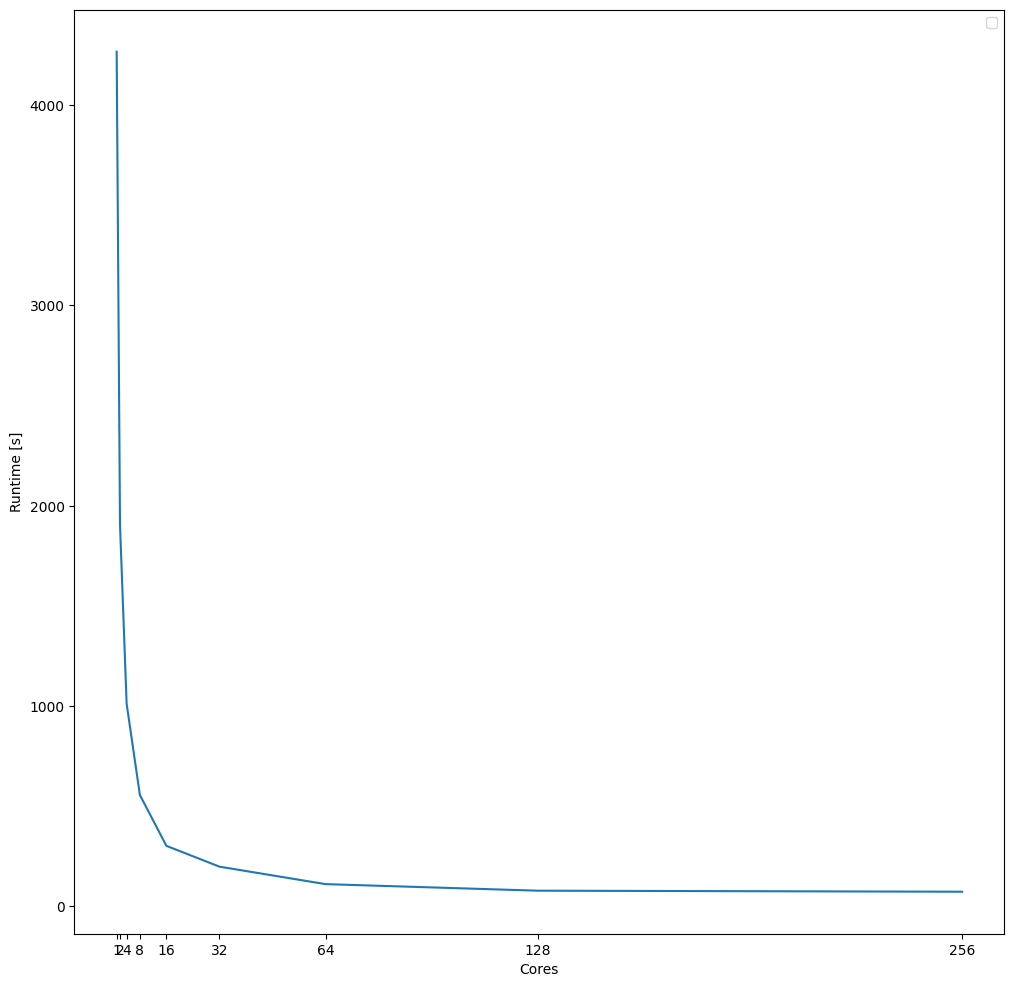

In [7]:
# Plot
fig, ax = pyplot.subplots(figsize=(12,12))
pyplot.xticks(df_avg.total_cores)
pyplot.xlabel("Cores")
pyplot.ylabel("Runtime [s]")
ax.plot(df_avg.total_cores, df_avg.time)
ax.legend()

# TGraph

Info in <TCanvas::Print>: png file throughput.png has been created


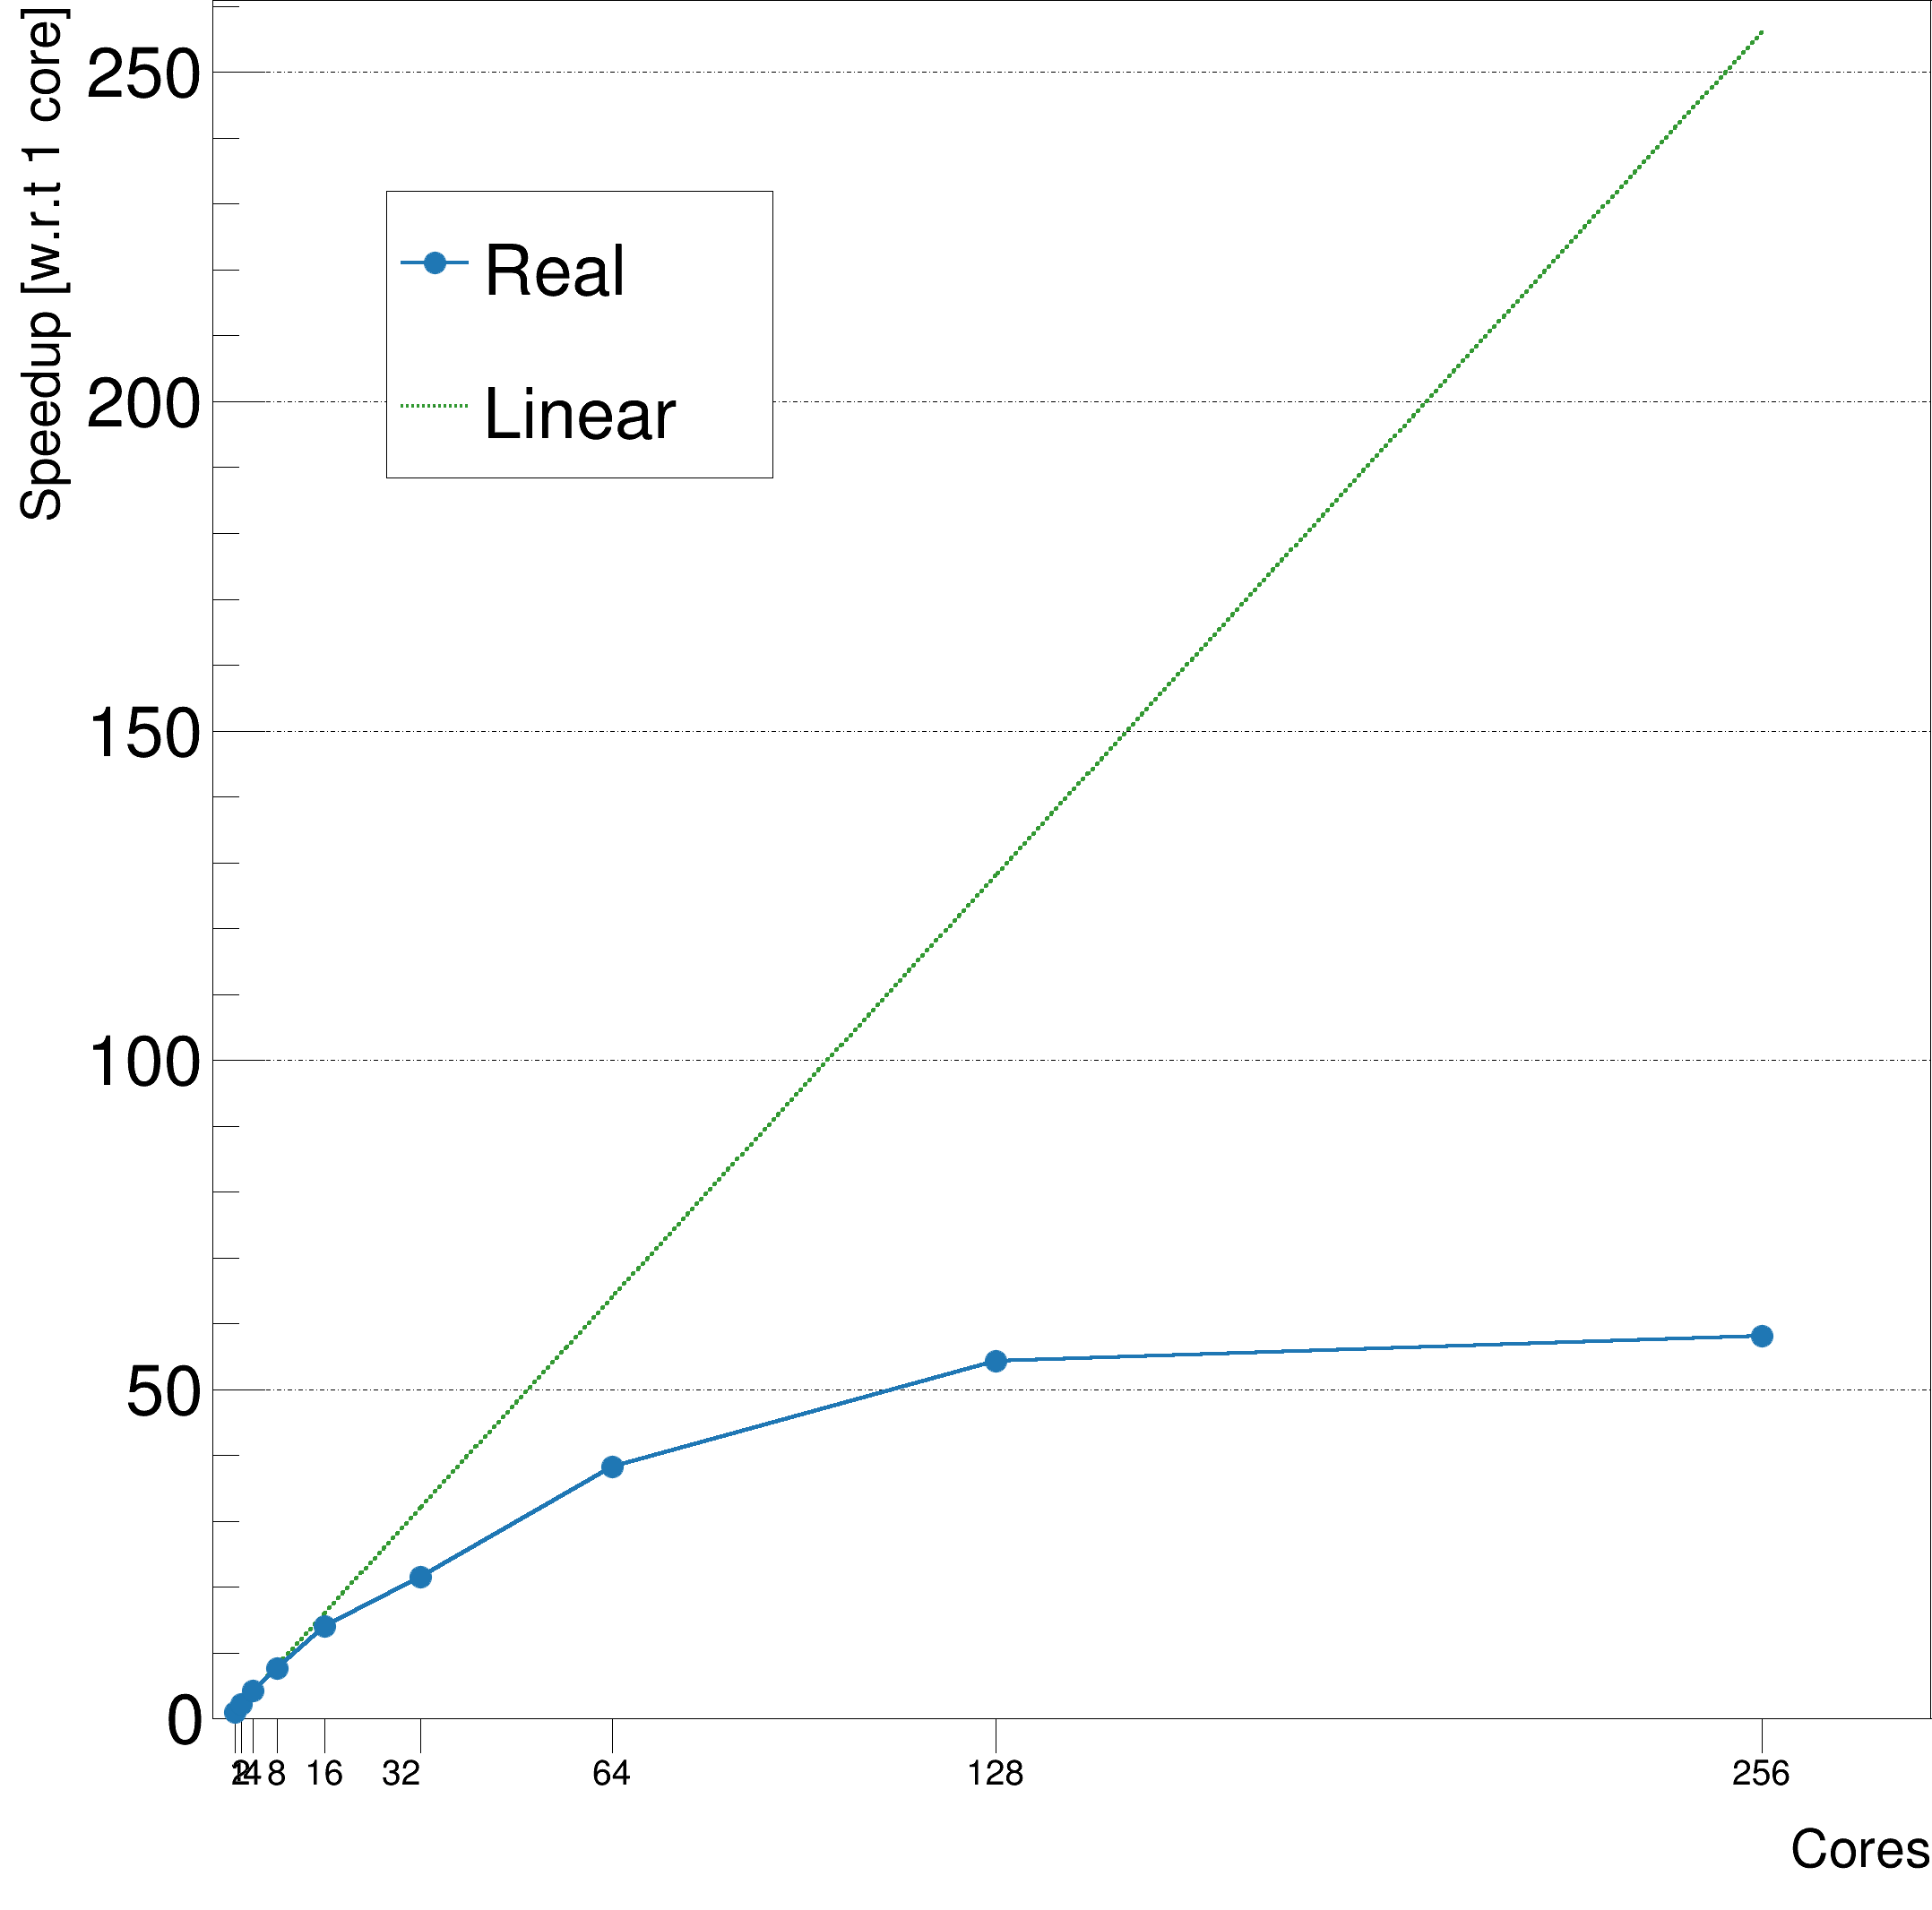

In [8]:
sparkgraph_cold = ROOT.TGraph(len(df_avg.total_cores),
                              numpy.array(df_avg.total_cores, dtype=float),
                              numpy.array(df_avg.speedup, dtype=float))

idealspeedupgraph = ROOT.TGraph(len(df_avg.total_cores),
                                numpy.array(df_avg.total_cores, dtype=float),
                                numpy.array(df_avg.total_cores, dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin, ymax = get_y_min_max(idealspeedupgraph, sparkgraph_cold)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Cores")
idealspeedupgraph.GetXaxis().SetTitleSize(0.03)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetXaxis().SetRangeUser(-5,300)

idealspeedupgraph.GetYaxis().SetTitle("Speedup [w.r.t 1 core]")
idealspeedupgraph.GetYaxis().SetTitleSize(0.03)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.8)
idealspeedupgraph.GetYaxis().SetRangeUser(0, ymax+5)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)
#idealspeedupgraph.GetYaxis().SetTickLength(0)

#idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
#idealspeedupgraph.SetMarkerSize(1)
#idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
idealspeedupgraph.SetLineWidth(4)
idealspeedupgraph.Draw("AL")



dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(df_avg.total_cores)):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -10, str(int(x)))
    xt.SetTextSize(0.02)
    xt.SetTextFont(42)
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
#    yt = ROOT.TLatex(-50, y-0.2, str(int(y)))
#    yt.SetTextSize(0.03)
#    yt.SetTextFont(42)
#    yt.SetTextAlign(21)
#    yt.Draw()
#    ylabels.append(yt)
#
#    yl = ROOT.TLine(0, y, 50, y)
#    yl.Draw()
#    yticks.append(yl)


sparkgraph_cold.GetYaxis().SetLabelSize(0)
sparkgraph_cold.SetMarkerSize(3)
sparkgraph_cold.SetMarkerStyle(20)
sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_cold.SetLineStyle(ROOT.kSolid)
sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_cold.SetLineWidth(4)

sparkgraph_cold.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(sparkgraph_cold, "Real")
legend.AddEntry(idealspeedupgraph, "Linear")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetGridy()

c.SetRightMargin(0)
c.SetLeftMargin(0.11)
c.SetTopMargin(0)
c.SetBottomMargin(0.1)

c.Draw()
c.SaveAs("throughput.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file speedup_log.png has been created


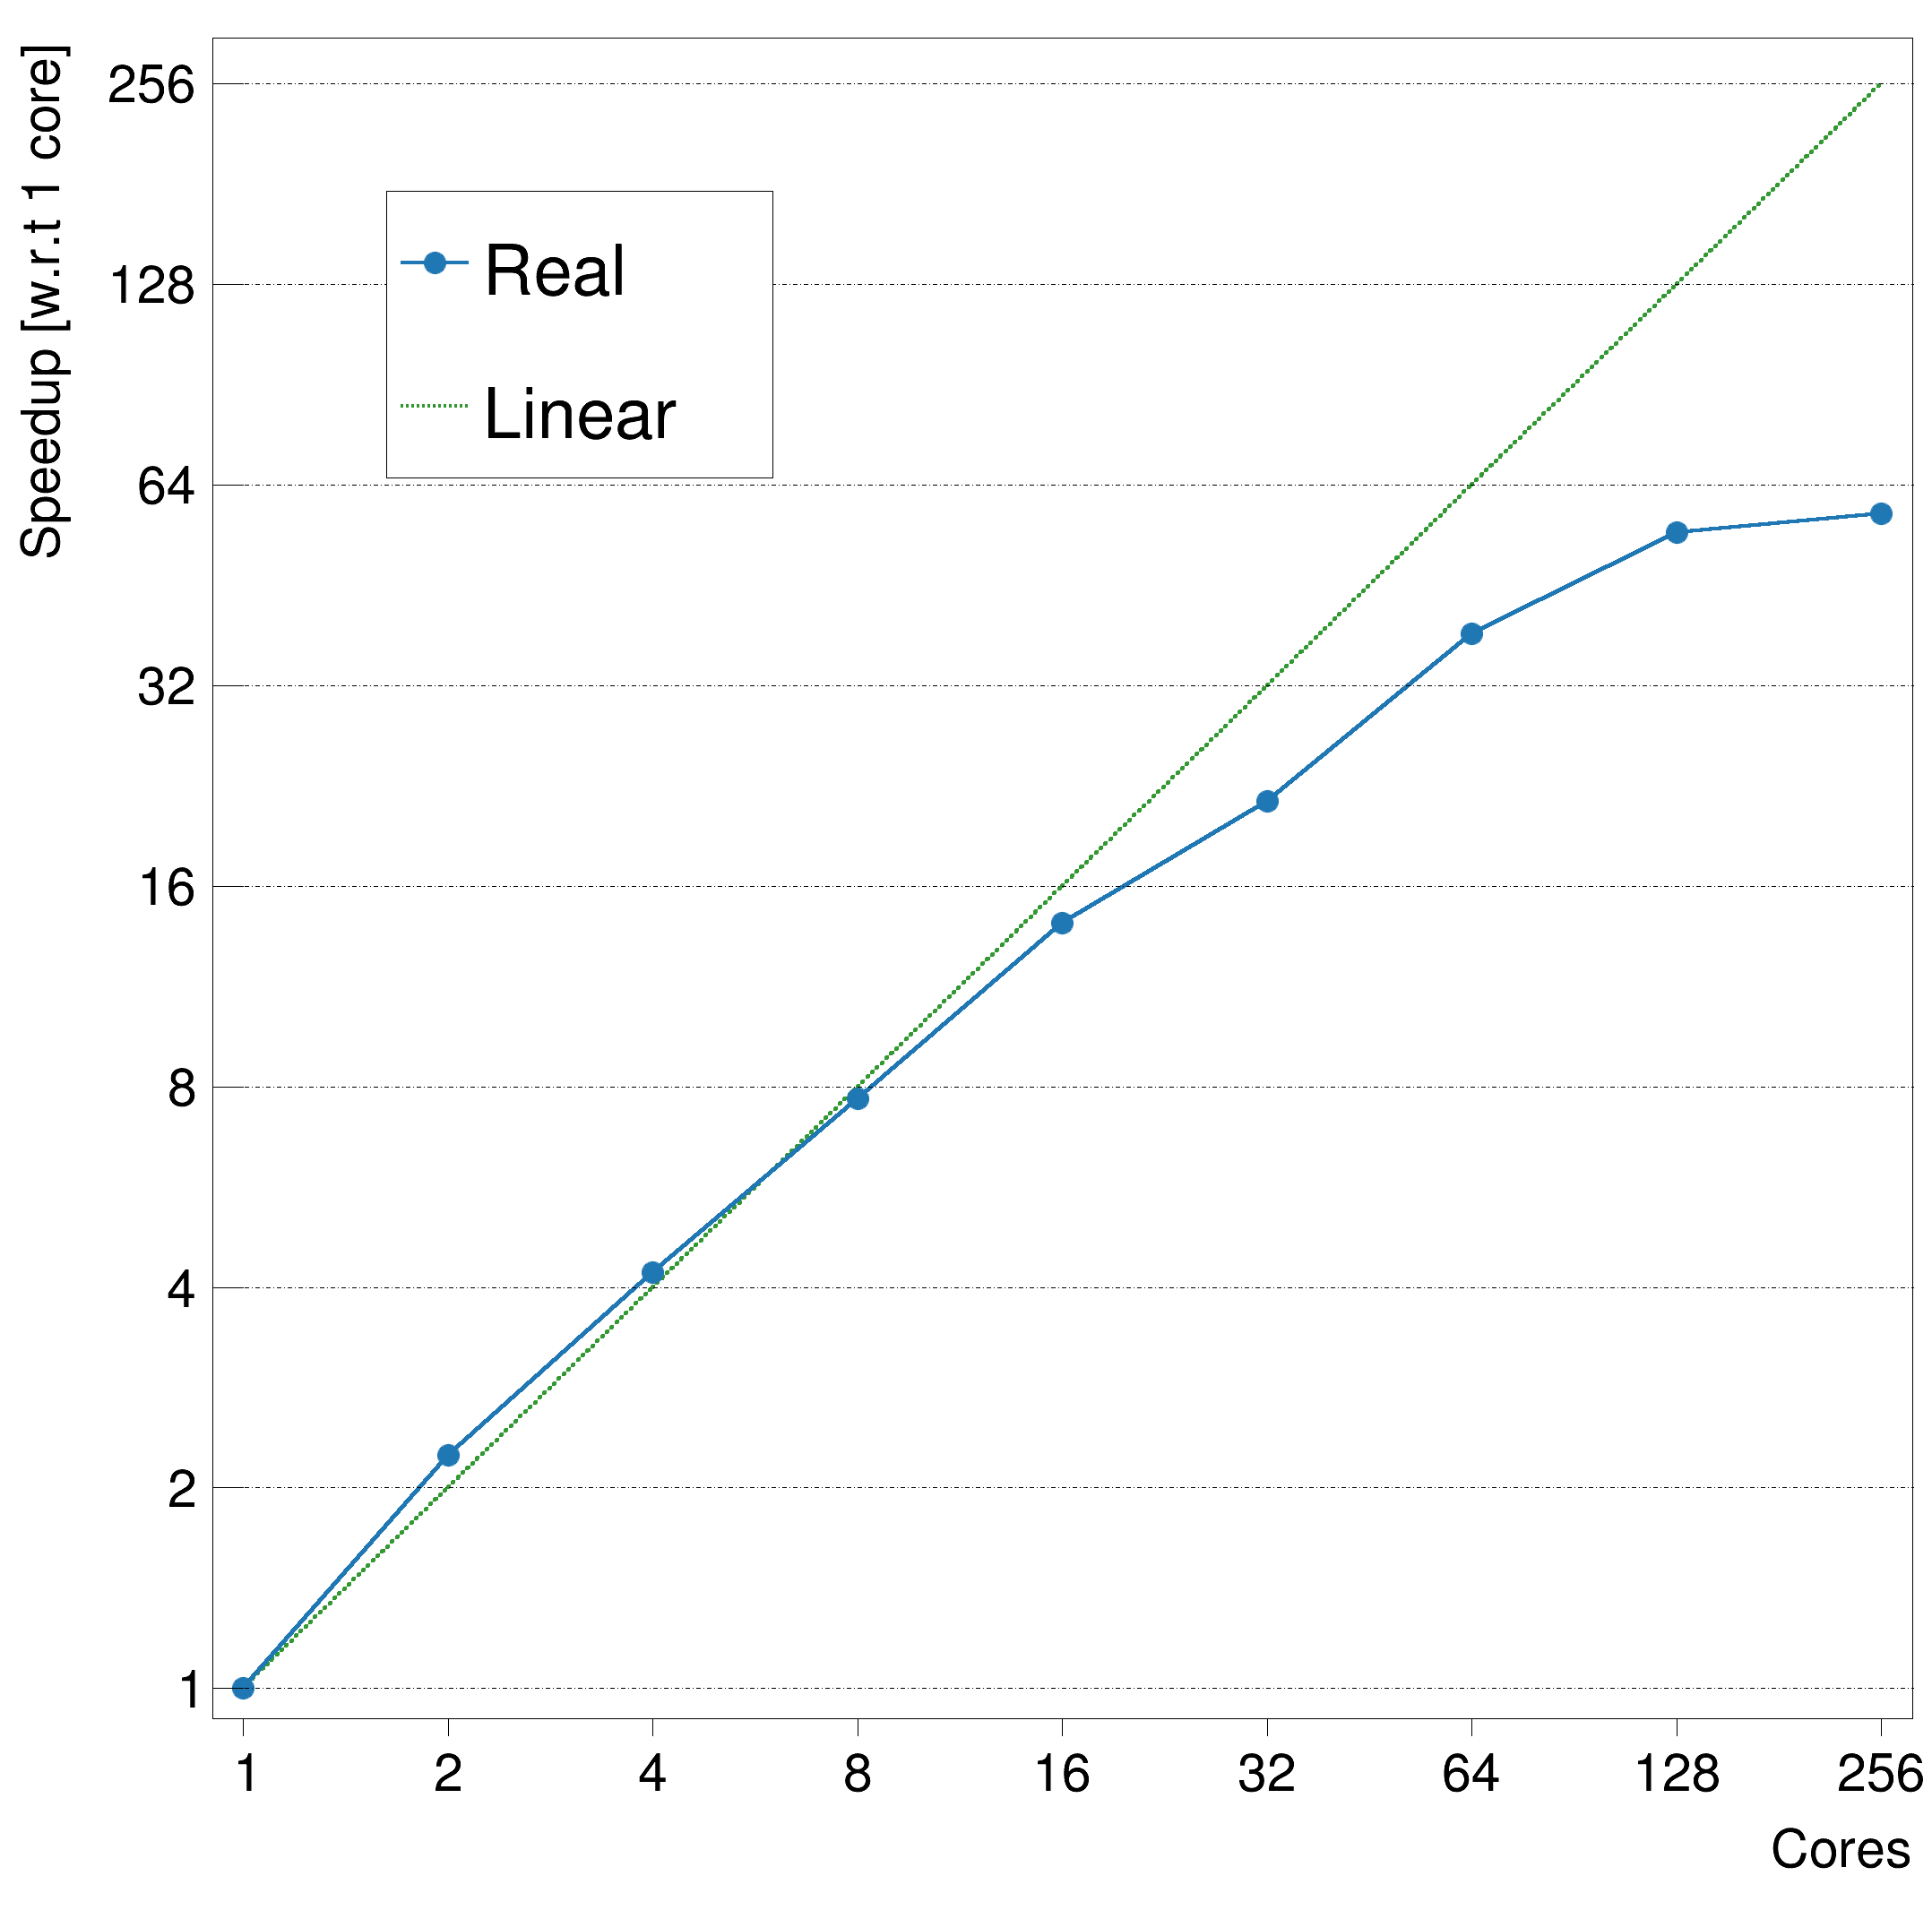

In [9]:
sparkgraph_cold = ROOT.TGraph(len(df_avg.total_cores),
                              numpy.array(df_avg.total_cores, dtype=float),
                              numpy.array(df_avg.speedup, dtype=float))

idealspeedupgraph = ROOT.TGraph(len(df_avg.total_cores),
                                numpy.array(df_avg.total_cores, dtype=float),
                                numpy.array(df_avg.total_cores, dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)
ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetLogx()
c.SetLogy()

ymin, ymax = get_y_min_max(idealspeedupgraph, sparkgraph_cold)
xaxis = idealspeedupgraph.GetXaxis()
yaxis = idealspeedupgraph.GetYaxis()

idealspeedupgraph.SetMinimum(0.9)
idealspeedupgraph.SetMaximum(300)

idealspeedupgraph.SetTitle("")

xaxis.SetTitle("Cores")
xaxis.SetTitleSize(0.03)
xaxis.SetTitleOffset(1.4)
xaxis.SetLabelSize(0)
xaxis.SetTickLength(0)
xaxis.SetRangeUser(-5,500)

yaxis.SetTitle("Speedup [w.r.t 1 core]")
yaxis.SetTitleSize(0.03)
yaxis.SetTitleOffset(1.8)
yaxis.SetRangeUser(0, ymax+5)
yaxis.SetLabelSize(0)
yaxis.SetTickLength(0)
yaxis.SetTickSize(0)

idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
idealspeedupgraph.SetLineWidth(4)
idealspeedupgraph.Draw("AL")

sparkgraph_cold.SetMarkerSize(3)
sparkgraph_cold.SetMarkerStyle(20)
sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_cold.SetLineStyle(ROOT.kSolid)
sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_cold.SetLineWidth(4)

sparkgraph_cold.Draw("SAME PL")

xaxis.SetTickLength(0)
yaxis.SetTickLength(0)

c.SetRightMargin(0.01)
c.SetLeftMargin(0.11)
c.SetTopMargin(0.02)
c.SetBottomMargin(0.1)

dy = ymax - ymin
xlabels = []
xticks = []
ylabels = []
yticks = []
for i in range(len(df_avg.total_cores)):
    # X axis labels/ticks
    x = idealspeedupgraph.GetPointX(i)
    
    xt = ROOT.TLatex()
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)

    xt.SetTextAlign(21)
    xt.DrawLatex(x,0.7, str(int(x))) # For some reason only this works in log axis
    xlabels.append(xt)

    xl = ROOT.TLine()
    xl.DrawLine(x,0,x,0.85)
    xticks.append(xl)

    # Y axis labels/ticks
    y = idealspeedupgraph.GetPointY(i)

    yt = ROOT.TLatex()
    yt.SetTextSize(0.03)
    yt.SetTextFont(42)
    yt.SetTextAlign(32)
    yt.DrawLatex(0.85, y, str(int(y)))
    ylabels.append(yt)

    yl = ROOT.TLine()
    yl.DrawLine(0.9, y, 1, y)
    yticks.append(yl)
    
    yl = ROOT.TLine()
    yl.SetLineStyle(5)
    yl.DrawLine(0.9, y, 285, y)
    yticks.append(yl)
    
legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(sparkgraph_cold, "Real")
legend.AddEntry(idealspeedupgraph, "Linear")
legend.Draw()

c.Draw()
c.SaveAs("speedup_log.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file runtime_log.png has been created


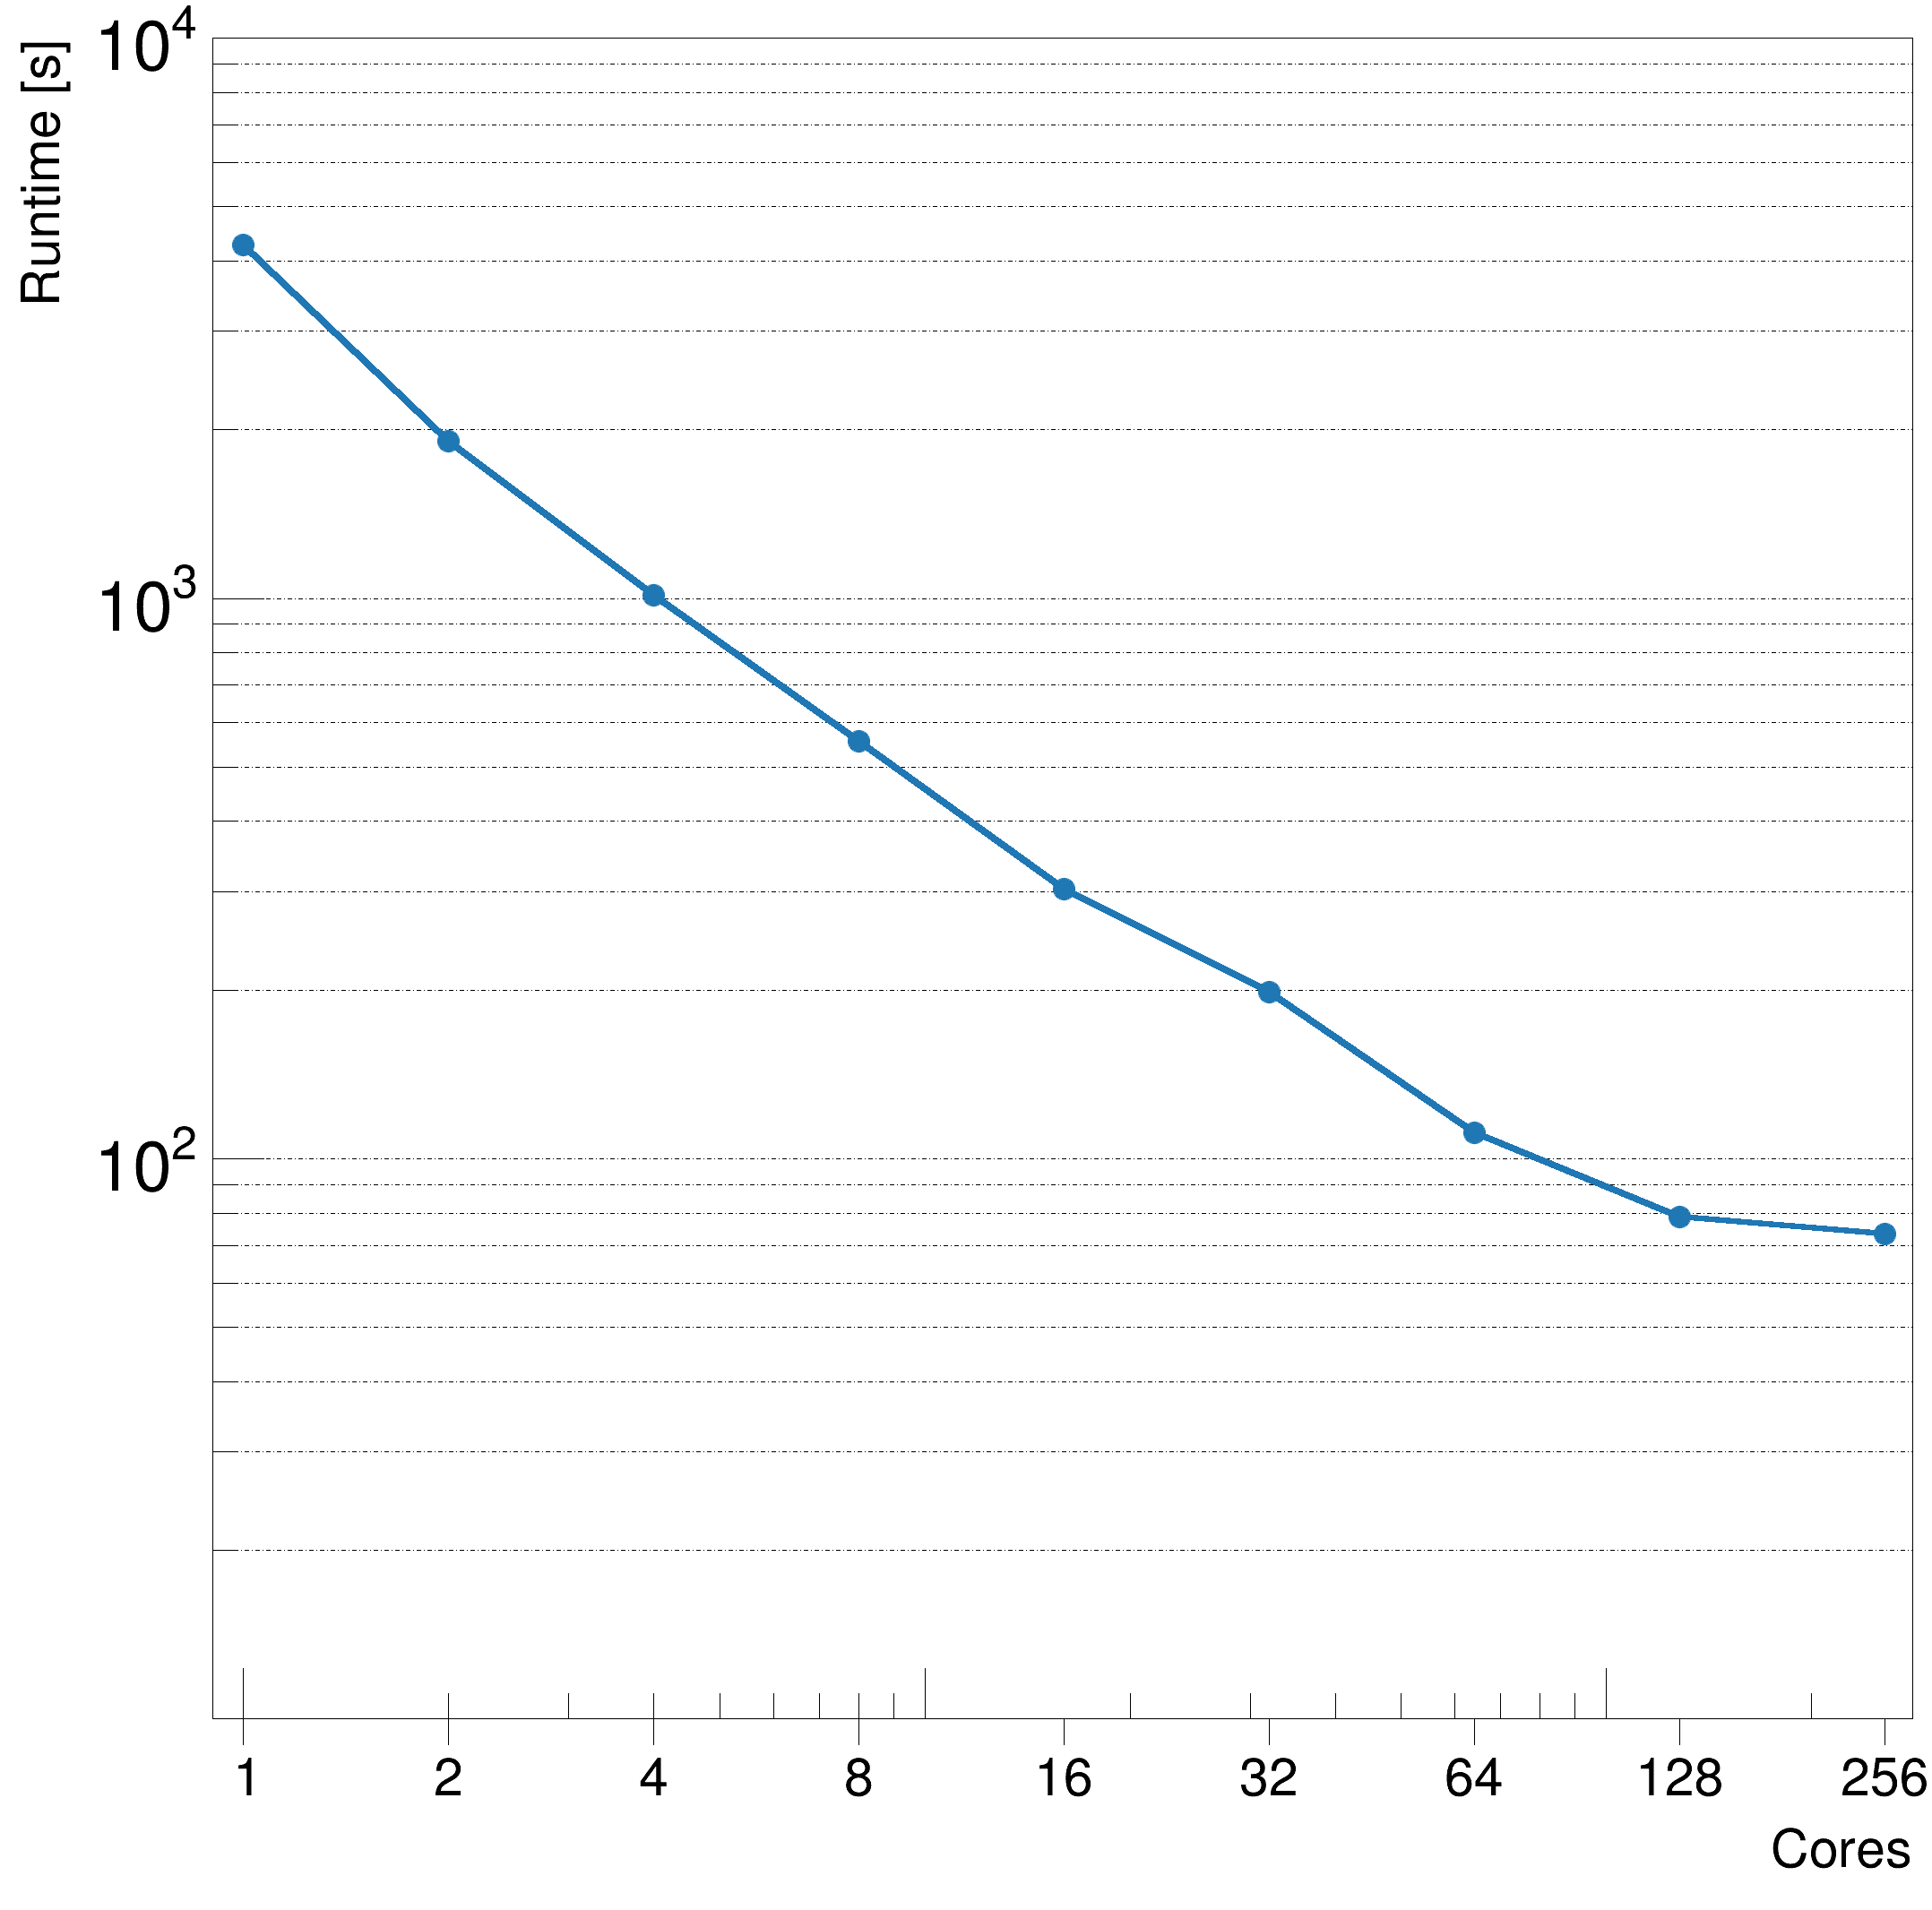

In [10]:
idealspeedupgraph = ROOT.TGraph(len(df_avg.total_cores),
                                numpy.array(df_avg.total_cores, dtype=float),
                                numpy.array(df_avg.time, dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin, ymax = get_y_min_max(idealspeedupgraph, idealspeedupgraph)

idealspeedupgraph.SetTitle("")

xaxis = idealspeedupgraph.GetXaxis()
yaxis = idealspeedupgraph.GetYaxis()

idealspeedupgraph.GetXaxis().SetTitle("Cores")
idealspeedupgraph.GetXaxis().SetTitleSize(0.03)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetXaxis().SetRangeUser(-5,500)

idealspeedupgraph.GetYaxis().SetTitle("Runtime [s]")
idealspeedupgraph.GetYaxis().SetTitleSize(0.03)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.8)
idealspeedupgraph.GetYaxis().SetRangeUser(0, ymax)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)
#idealspeedupgraph.GetYaxis().SetTickLength(0)

idealspeedupgraph.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
idealspeedupgraph.SetMarkerSize(3)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kSolid)
idealspeedupgraph.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
idealspeedupgraph.SetLineWidth(6)

xaxis.SetMoreLogLabels()
xaxis.SetNoExponent()
yaxis.SetMoreLogLabels()

idealspeedupgraph.SetMinimum(10)
idealspeedupgraph.SetMaximum(1e4)
idealspeedupgraph.Draw("ALP")



#ylabels = []
#yticks = []
 
#    yt = ROOT.TLatex(-50, y-0.2, str(int(y)))
#    yt.SetTextSize(0.03)
#    yt.SetTextFont(42)
#    yt.SetTextAlign(21)
#    yt.Draw()
#    ylabels.append(yt)
#
#    yl = ROOT.TLine(0, y, 50, y)
#    yl.Draw()
#    yticks.append(yl)



#sparkgraph_cold.GetYaxis().SetLabelSize(0)
#sparkgraph_cold.SetMarkerSize(3)
#sparkgraph_cold.SetMarkerStyle(20)
#sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
#sparkgraph_cold.SetLineStyle(ROOT.kSolid)
#sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
#sparkgraph_cold.SetLineWidth(4)

#sparkgraph_cold.Draw("SAME PL")

#legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
#legend.AddEntry(sparkgraph_cold, "Real")
#legend.AddEntry(idealspeedupgraph, "Run")
#legend.Draw()


#ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetGridy()
c.SetLogy()
c.SetLogx()

c.SetRightMargin(0.01)
c.SetLeftMargin(0.11)
c.SetTopMargin(0.02)
c.SetBottomMargin(0.1)

dy = ymax - ymin
xlabels = []
xticks = []
for i in range(len(df_avg.total_cores)):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)
    xt = ROOT.TLatex()
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    """
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    """
    xt.SetTextAlign(21)
    xt.DrawLatex(x,7.3, str(int(x))) # For some reason only this works in log axis
    xlabels.append(xt)

    xl = ROOT.TLine()
    xl.DrawLine(x,0,x,9)
    xticks.append(xl)


c.Draw()
c.SaveAs("runtime_log.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file runtime_sem.png has been created


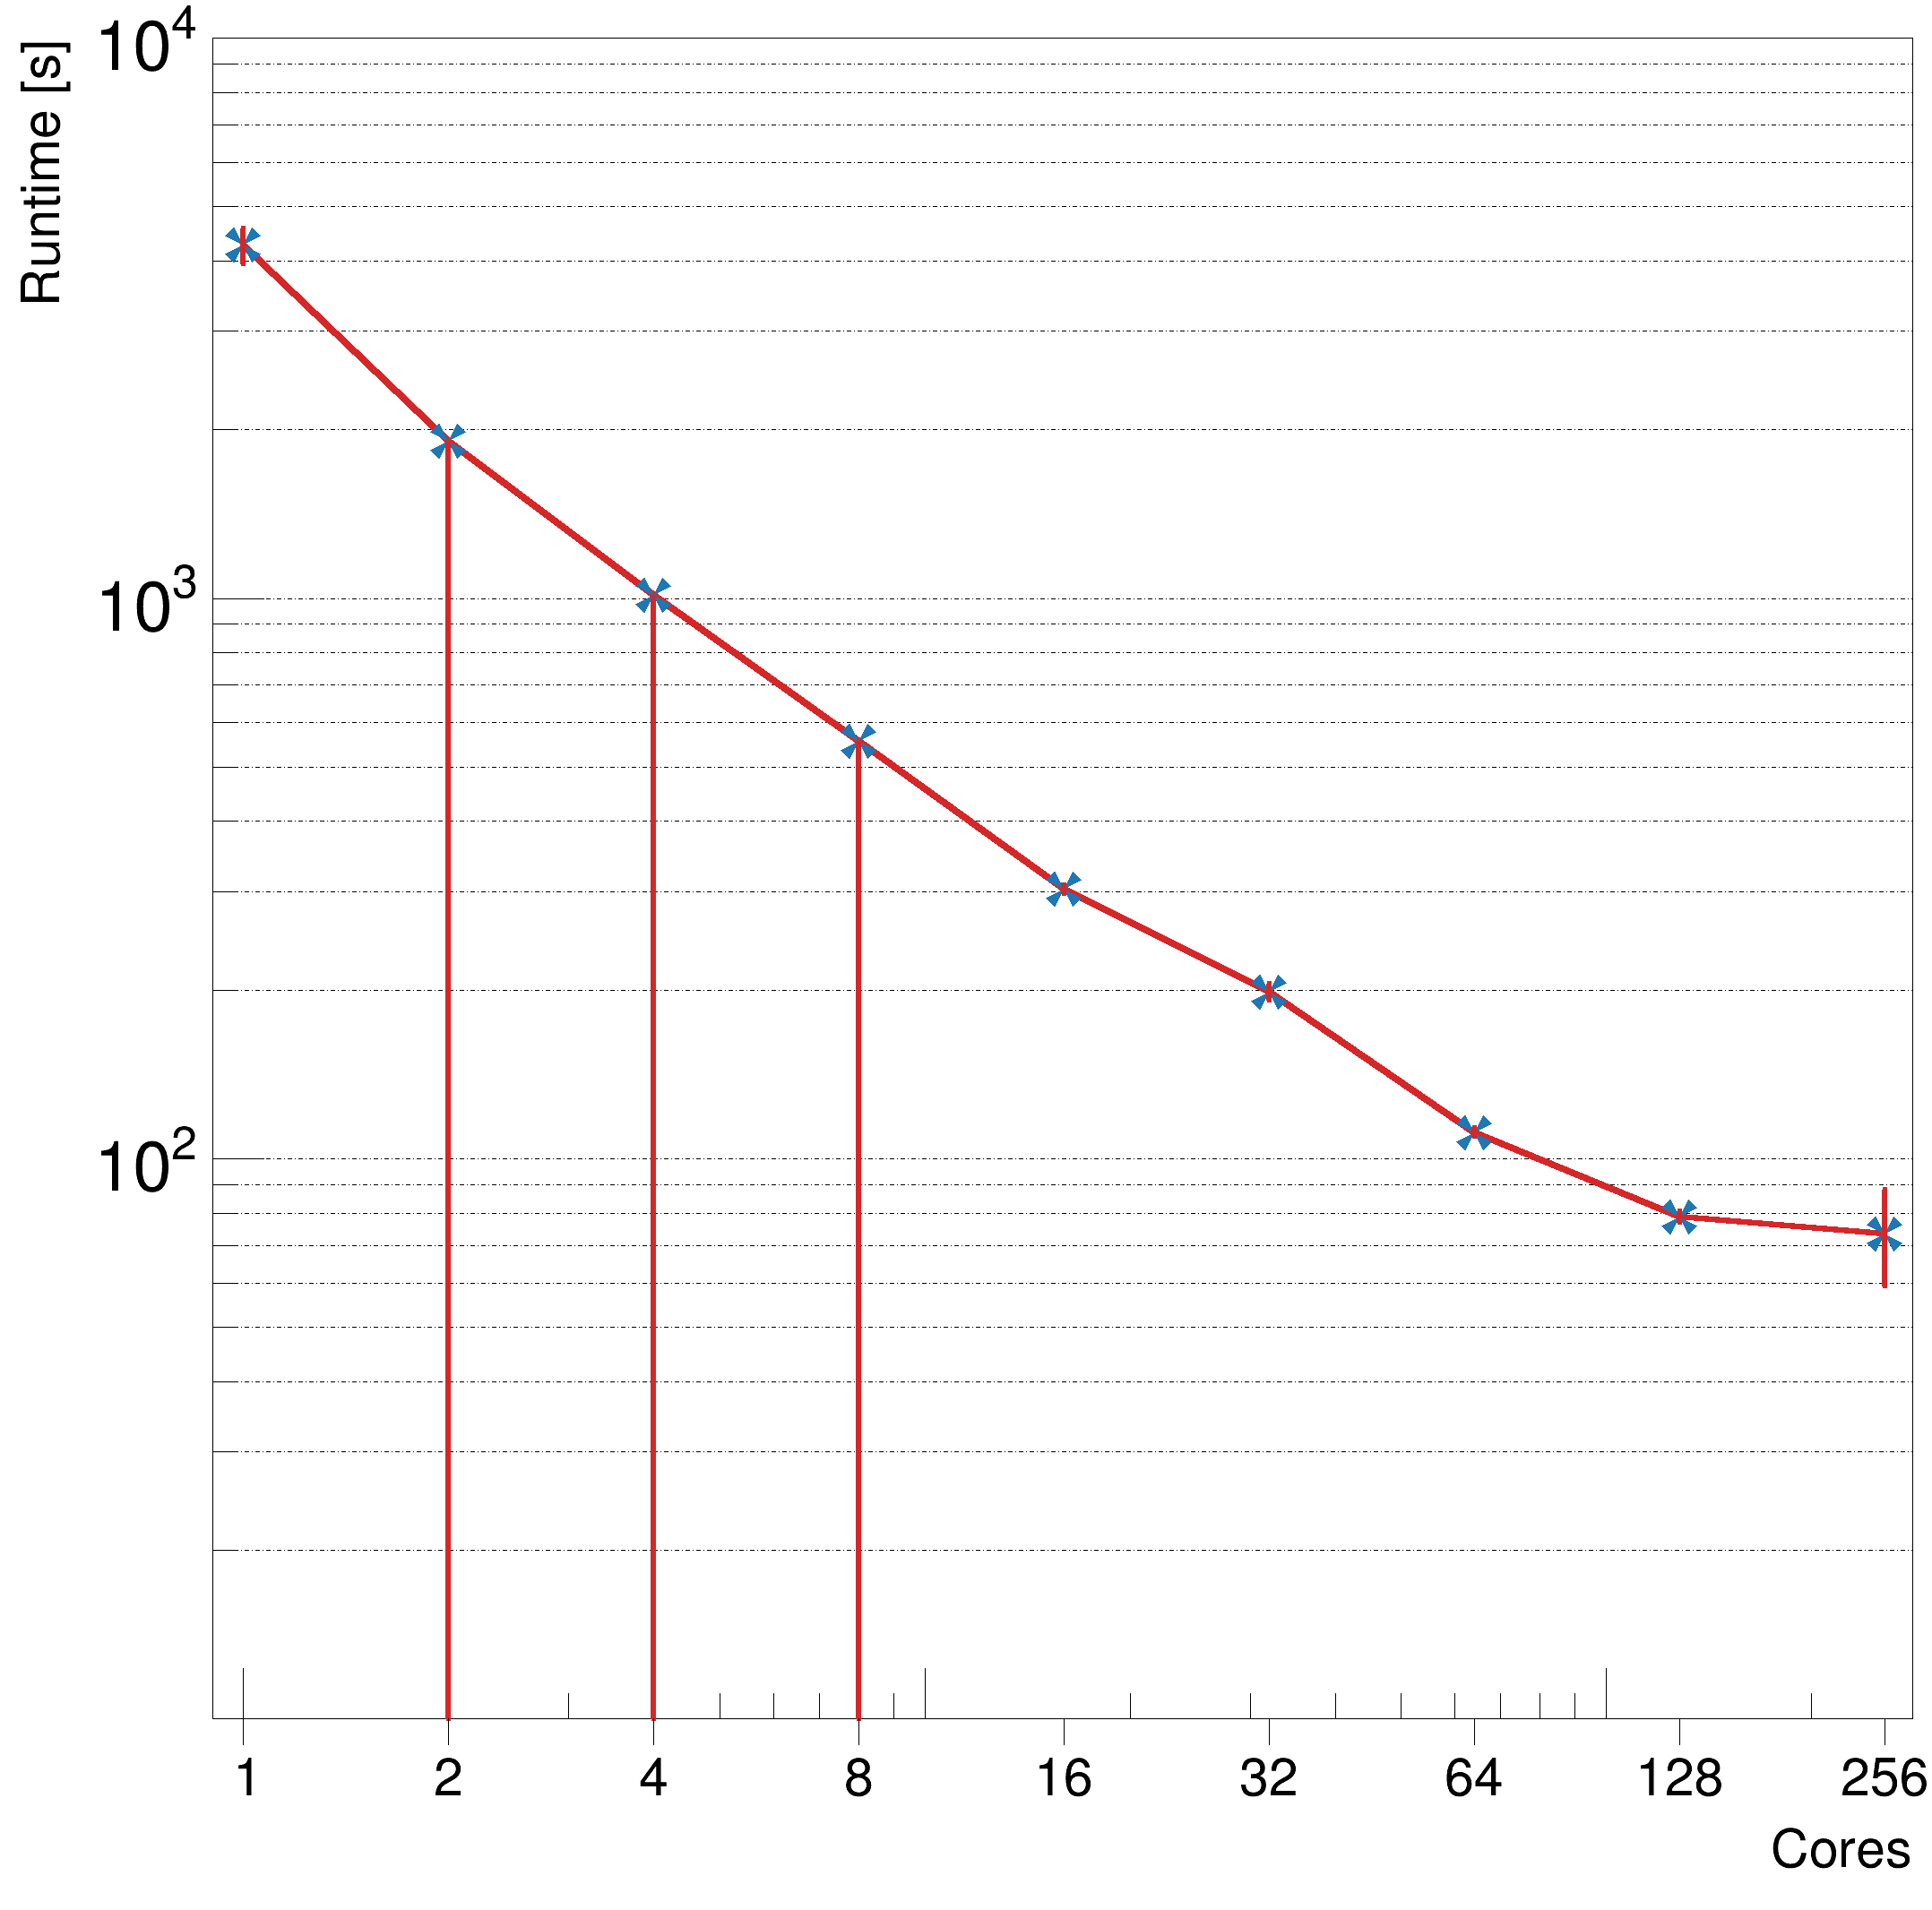

In [11]:
npoints = len(df_avg.total_cores)
valuesx = numpy.array(df_avg.total_cores, dtype=float)
valuesy = numpy.array(df_avg.time, dtype=float)
errx = 0
erry = numpy.array(df_avg["sem"], dtype=float)


idealspeedupgraph = ROOT.TGraphErrors(
    npoints,
    valuesx,
    valuesy,
    errx,
    erry
)


width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin, ymax = get_y_min_max(idealspeedupgraph, idealspeedupgraph)

idealspeedupgraph.SetTitle("")

xaxis = idealspeedupgraph.GetXaxis()
yaxis = idealspeedupgraph.GetYaxis()

idealspeedupgraph.GetXaxis().SetTitle("Cores")
idealspeedupgraph.GetXaxis().SetTitleSize(0.03)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetXaxis().SetRangeUser(-5,500)

idealspeedupgraph.GetYaxis().SetTitle("Runtime [s]")
idealspeedupgraph.GetYaxis().SetTitleSize(0.03)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.8)
idealspeedupgraph.GetYaxis().SetRangeUser(0, ymax)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)
idealspeedupgraph.GetYaxis().SetMoreLogLabels()
#idealspeedupgraph.GetYaxis().SetTickLength(0)

idealspeedupgraph.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
idealspeedupgraph.SetMarkerSize(5)
idealspeedupgraph.SetMarkerStyle(41)
idealspeedupgraph.SetLineStyle(ROOT.kSolid)
idealspeedupgraph.SetLineColorAlpha(PYPLOT_TCOLORS["tab:red"],1)
idealspeedupgraph.SetLineWidth(6)

xaxis.SetMoreLogLabels()
xaxis.SetNoExponent()
yaxis.SetMoreLogLabels()

idealspeedupgraph.SetMinimum(10)
idealspeedupgraph.SetMaximum(1e4)
idealspeedupgraph.Draw("ALP")



#ylabels = []
#yticks = []
 
#    yt = ROOT.TLatex(-50, y-0.2, str(int(y)))
#    yt.SetTextSize(0.03)
#    yt.SetTextFont(42)
#    yt.SetTextAlign(21)
#    yt.Draw()
#    ylabels.append(yt)
#
#    yl = ROOT.TLine(0, y, 50, y)
#    yl.Draw()
#    yticks.append(yl)



#sparkgraph_cold.GetYaxis().SetLabelSize(0)
#sparkgraph_cold.SetMarkerSize(3)
#sparkgraph_cold.SetMarkerStyle(20)
#sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
#sparkgraph_cold.SetLineStyle(ROOT.kSolid)
#sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
#sparkgraph_cold.SetLineWidth(4)

#sparkgraph_cold.Draw("SAME PL")

#legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
#legend.AddEntry(sparkgraph_cold, "Real")
#legend.AddEntry(idealspeedupgraph, "Run")
#legend.Draw()


#ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetGridy()
c.SetLogy()
c.SetLogx()

c.SetRightMargin(0.01)
c.SetLeftMargin(0.11)
c.SetTopMargin(0.02)
c.SetBottomMargin(0.1)

dy = ymax - ymin
xlabels = []
xticks = []
for i in range(len(df_avg.total_cores)):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)
    xt = ROOT.TLatex()
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    """
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    """
    xt.SetTextAlign(21)
    xt.DrawLatex(x,7.3, str(int(x))) # For some reason only this works in log axis
    xlabels.append(xt)

    xl = ROOT.TLine()
    xl.DrawLine(x,0,x,9)
    xticks.append(xl)


c.Draw()
c.SaveAs("runtime_sem.png")